<a href="https://colab.research.google.com/github/naveentheog/Stock-Price-Predicition/blob/main/1Stock_Price_Prediction_using_Machine_Learning_in_Python_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import yfinance as yf
import pandas as pd
import os

In [60]:
    sp500 = yf.Ticker("AAPL")
    sp500 = sp500.history(period="max")
    #print(ticker.info['longName'])
    sp500


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.098485,0.098913,0.098485,0.098485,469033600,0.00,0.0
1980-12-15 00:00:00-05:00,0.093775,0.093775,0.093347,0.093347,175884800,0.00,0.0
1980-12-16 00:00:00-05:00,0.086924,0.086924,0.086495,0.086495,105728000,0.00,0.0
1980-12-17 00:00:00-05:00,0.088636,0.089064,0.088636,0.088636,86441600,0.00,0.0
1980-12-18 00:00:00-05:00,0.091206,0.091634,0.091206,0.091206,73449600,0.00,0.0
...,...,...,...,...,...,...,...
2025-08-06 00:00:00-04:00,205.396898,215.135845,205.356935,213.008255,108483100,0.00,0.0
2025-08-07 00:00:00-04:00,218.631873,220.599641,216.334477,219.780563,90224800,0.00,0.0
2025-08-08 00:00:00-04:00,220.579666,230.738135,219.001455,229.090012,113854000,0.00,0.0


<Axes: xlabel='Date'>

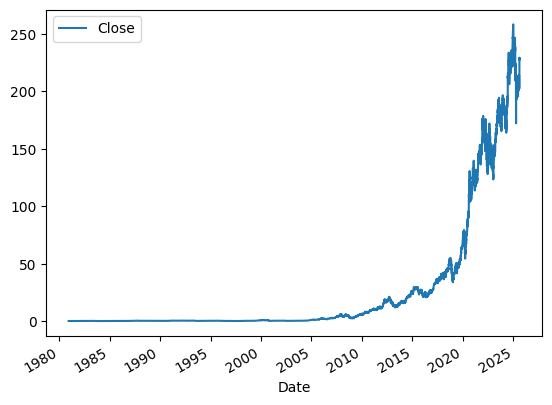

In [61]:
#ticker = sp500
sp500.plot.line(y="Close", use_index=True)

In [20]:
# del ticker["Dividends"]
# del ticker["Stock Splits"]

In [63]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [64]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [65]:
sp500 = sp500.loc["1990-01-01":].copy()

In [66]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [67]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.550561797752809

<Axes: xlabel='Date'>

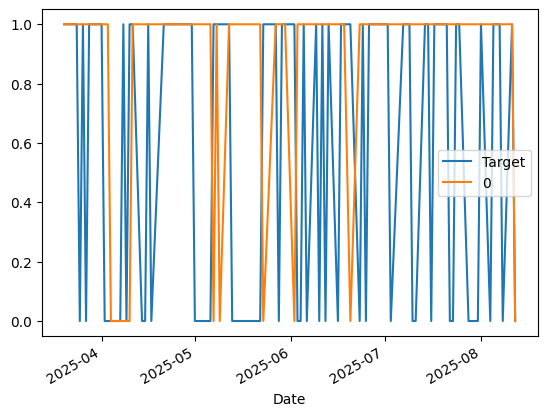

In [68]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [69]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [70]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [72]:
predictions = backtest(sp500, model, predictors)

In [43]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3804
1,2665


In [73]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5154541131716596

In [74]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.523265
0,0.476735


In [75]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [76]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [77]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,0.214030,0.217688,0.212200,0.213115,293664000,0.00,0.0,0.217688,1,0.993604,1.0,0.978993,1.0,1.007241,22.0,0.694753,111.0,0.637248,462.0
1993-12-15 00:00:00-05:00,0.212200,0.217688,0.212200,0.217688,123883200,0.00,0.0,0.214944,0,1.010615,1.0,1.014493,2.0,1.025699,23.0,0.711547,111.0,0.651010,462.0
1993-12-16 00:00:00-05:00,0.215859,0.217688,0.212200,0.214944,126369600,0.00,0.0,0.215859,1,0.993658,1.0,1.005993,2.0,1.010468,22.0,0.704569,110.0,0.642898,461.0
1993-12-17 00:00:00-05:00,0.215859,0.217688,0.213115,0.215859,145152000,0.00,0.0,0.208541,0,1.002123,1.0,1.001698,3.0,1.011960,23.0,0.709636,110.0,0.645728,461.0
1993-12-20 00:00:00-05:00,0.214030,0.217688,0.206712,0.208541,189033600,0.00,0.0,0.201224,0,0.982758,1.0,0.974358,2.0,0.975653,22.0,0.687599,110.0,0.623946,460.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-06 00:00:00-04:00,205.396898,215.135845,205.356935,213.008255,108483100,0.00,0.0,219.780563,1,1.024822,1.0,1.035727,2.0,1.035381,32.0,0.962925,138.0,1.185816,532.0
2025-08-07 00:00:00-04:00,218.631873,220.599641,216.334477,219.780563,90224800,0.00,0.0,229.090012,1,1.015648,2.0,1.055877,3.0,1.067501,32.0,0.993339,138.0,1.223013,532.0
2025-08-08 00:00:00-04:00,220.579666,230.738135,219.001455,229.090012,113854000,0.00,0.0,227.179993,0,1.020740,2.0,1.072832,4.0,1.111243,32.0,1.035096,138.0,1.274228,532.0


In [78]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [79]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [81]:
predictions = backtest(sp500, model, new_predictors)

In [82]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,4902
1.0,567


In [83]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5308641975308642

In [84]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.531907
0,0.468093


In [85]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,0.0
2003-11-18 00:00:00-05:00,1,0.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,0,0.0
...,...,...
2025-08-06 00:00:00-04:00,1,0.0
2025-08-07 00:00:00-04:00,1,0.0
2025-08-08 00:00:00-04:00,0,0.0
